# Roberta

## import

In [52]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
import twint
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from green_mood_tracker.training_data import get_raw_data_notebook
from green_mood_tracker.data_cleaning import clean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## get data and clean

In [53]:
raw_data = get_raw_data_notebook()
raw_data_clean = clean(raw_data,'text')
raw_data_clean.head()

/Users/henryhall/.pyenv/versions/3.7.7/envs/lewagon-3.7/lib/python3.7/site-packages/green_mood_tracker/training_data.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  sentiment140_final['source'] = 'sentiment140'


,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0,sts_gold
2,1467968979,april th isnt coming soon enough,0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0,sts_gold


In [54]:
raw_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36472 entries, 0 to 4541
Data columns (total 4 columns):
id          36472 non-null object
text        36472 non-null object
polarity    36472 non-null int64
source      36472 non-null object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [55]:
raw_data_clean.polarity.value_counts()

1    14880
2    10836
0    10756
Name: polarity, dtype: int64

In [56]:
raw_data_clean = raw_data_clean[raw_data_clean['polarity']!=1]

In [57]:
# remove sentiment 140 data
data_sample = raw_data_clean[raw_data_clean['source']!='sentiment140']

In [58]:
data_sample['polarity'] = data_sample.polarity.map({2:1,0:0})
data_sample.head()

,id,text,polarity,source
0,1467933112,angel going miss athlete weekend,0,sts_gold
1,2323395086,look though shaq getting traded cleveland play...,0,sts_gold
2,1467968979,april th isnt coming soon enough,0,sts_gold
3,1990283756,drinking mcdonalds coffee understanding someon...,0,sts_gold
4,1988884918,dissapointed taylor swift doesnt twitter,0,sts_gold


## take sample if neccessary

In [59]:
data_sample = data_sample.sample(n=100,random_state=0).reset_index()
data_sample.head()

,index,id,text,polarity,source
0,156,2060852332,dad threw im grandma tonight need drinking bud...,0,sts_gold
1,2532,3a07e1cf57,playing bejewled facebook want higherscore,0,kaggle_sentiment_test
2,10632,756b4e674b,stupid competition stuff keep getting way goin...,0,kaggle_sentiment_train
3,9533,c6149b7abf,castiel angle,1,kaggle_sentiment_train
4,7434,e2e0d8b057,class tomorrow tomorrow saturday hate class sa...,0,kaggle_sentiment_train


In [60]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
index       100 non-null int64
id          100 non-null object
text        100 non-null object
polarity    100 non-null int64
source      100 non-null object
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


In [61]:
data_sample.polarity.value_counts()

0    56
1    44
Name: polarity, dtype: int64

## train test val split

In [62]:
from sklearn.model_selection import train_test_split

X = data_sample.text
y = data_sample.polarity

sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)

In [63]:
sentence_train, sentence_val, y_train, y_val = train_test_split(sentence_train, y_train, test_size=0.3, random_state = 0)

## build roberta

In [28]:
#!pip install absl-py --quiet

In [29]:
#!pip install tensorflow-datasets --quiet

In [30]:
#!pip install transformers --quiet

In [31]:
!pip install torch

You should consider upgrading via the 'pip install --upgrade pip' command.


In [64]:
from sklearn.metrics import f1_score
import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification, TFRobertaModel
from transformers import RobertaTokenizerFast
from transformers import AdamWeightDecay

## convert tweets to features

In [65]:
# download pretraine tokenizer
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [66]:
max_length = 30
def convert_example_to_feature(entry):
    # combine step for tokenization, WordPiece vector mapping and will
    # add also special tokens and truncate reviews longer than our max length
    return roberta_tokenizer.encode_plus(entry,
                                 add_special_tokens=True,  # add [CLS], [SEP]
                                 max_length=max_length,  # max length of the text that can go to RoBERTa
                                 truncation=True,
                                 padding= 'max_length',  # add [PAD] tokens at the end of sentence
                                 return_attention_mask=True,  # add attention mask to not focus on pad tokens
                                 )

In [67]:
# map to the expected input to TFRobertaForSequenceClassification, see here
def map_example_to_dict(input_ids, attention_masks, label):
    return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label

In [68]:
def encode_examples(ds, limit=-1):
    # Prepare Input list
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if (limit > 0):
        ds = ds.take(limit)

    for entry, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(entry.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                               attention_mask_list,
                                               label_list)).map(map_example_to_dict)

In [69]:
max_length = 5
batch_size = 256


training_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_train,
                                                                  y_train))

val_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_val,
                                                                 y_val))

testing_sentences_modified = tf.data.Dataset.from_tensor_slices((sentence_test,
                                                                 y_test))

ds_train_encoded = encode_examples(training_sentences_modified).shuffle(10000).batch(batch_size)
ds_val_encoded = encode_examples(val_sentences_modified).batch(batch_size)
ds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)

In [70]:
ds_train_encoded

<BatchDataset shapes: ({input_ids: (None, 5), attention_mask: (None, 5)}, (None, 1)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

## build model

In [71]:
learning_rate = 7e-5

In [72]:
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaForSequenceClassification: ['lm_head']
- This IS expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## train model

In [73]:
from tensorflow.keras.callbacks import EarlyStopping
number_of_epochs = 2
es = EarlyStopping(patience=5,restore_best_weights=True,monitor='val_accuracy')
history = model.fit(ds_train_encoded, epochs=3,
          validation_data=ds_val_encoded, callbacks=[es])

Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.6893 - accuracy: 0.5714 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 2/3
1/1 [==============================] - 0s 168ms/step - loss: 0.6590 - accuracy: 0.6122 - val_loss: 0.6852 - val_accuracy: 0.5714
Epoch 3/3
1/1 [==============================] - 0s 135ms/step - loss: 0.6635 - accuracy: 0.6122 - val_loss: 0.6934 - val_accuracy: 0.5714


## plot and evaluate

In [28]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

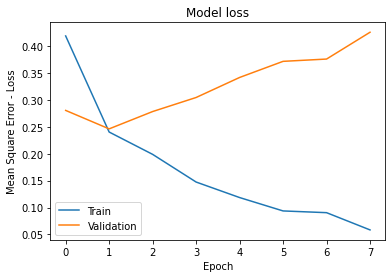

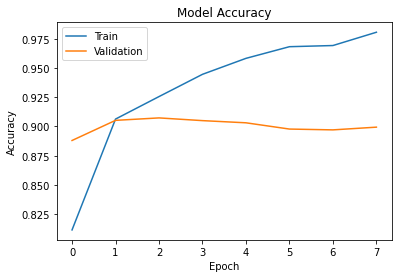

In [111]:
plot_loss(history)

In [44]:
model.evaluate(ds_test_encoded)

1/1 [==============================] - 0s 926us/step - loss: 0.6804 - accuracy: 0.5667


[0.6803866028785706, 0.5666666626930237]

## donwload model

In [49]:
from tensorflow.keras import models
model.save_pretrained('model_roBERTa_binary_3')

In [50]:
model_load = TFRobertaForSequenceClassification.from_pretrained('model_roBERTa_binary_3')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at model_roBERTa_binary_3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [51]:
tf.nn.softmax(model_load.predict(ds_test_encoded))

<tf.Tensor: shape=(1, 30, 2), dtype=float32, numpy=
array([[[0.58961856, 0.4103815 ],
        [0.59097755, 0.40902245],
        [0.591734  , 0.40826604],
        [0.5822634 , 0.41773656],
        [0.5914101 , 0.40858984],
        [0.56969535, 0.43030465],
        [0.5828124 , 0.41718757],
        [0.59329   , 0.40670997],
        [0.5926512 , 0.40734875],
        [0.5798232 , 0.42017677],
        [0.59514034, 0.40485966],
        [0.5972545 , 0.40274554],
        [0.5936771 , 0.40632284],
        [0.5556772 , 0.44432282],
        [0.5743452 , 0.42565486],
        [0.5806917 , 0.41930827],
        [0.5928668 , 0.40713322],
        [0.5909864 , 0.40901366],
        [0.5862361 , 0.41376388],
        [0.5846127 , 0.41538724],
        [0.57518953, 0.42481044],
        [0.5925351 , 0.40746492],
        [0.5875831 , 0.41241685],
        [0.58878374, 0.41121623],
        [0.5871607 , 0.41283932],
        [0.5926171 , 0.40738294],
        [0.584662  , 0.415338  ],
        [0.6071954 , 0.3928046

## incorporate some custom metric scoring and saving later maybe

In [117]:
# class ModelMetrics(tf.keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.count_n = 1

#     def on_epoch_end(self, batch, logs={}):
        
#         os.mkdir('/create/directory/for/model/' + str(self.count_n))
#         self.model.save_pretrained('/save/trained/model/here/' + str(self.count_n)) # this folder address should match with folder we created above
        
#         y_val_pred = tf.nn.softmax(self.model.predict(ds_test_encoded))
#         y_pred_argmax = tf.math.argmax(y_val_pred, axis=1)
#         testing_copy = testing_sentences.copy()
#         testing_copy['predicted'] = y_pred_argmax
#         f1_s = f1_score(testing_sentences['label'], testing_copy['predicted'])
#         print('\n f1 score is :', f1_s)
#         self.count_n += 1

# metrics = ModelMetrics()

## tuning

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
clf = KerasClassifier(twoLayerFeedForward, epochs=100, batch_size=500, verbose=0)

In [ ]:
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [ ]:
from tensorboard.plugins.hparams import api as hp

In [ ]:
HP_LEARNING_RATE = hp.HParam('num_units', hp.Discrete([1, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(x_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(x_test, y_test)
  return accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
model.fit(
    ...,
    callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ],
)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning